In [1]:
%run "..\Startup_py3.py"
sys.path.append(r"C:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

16928


In [2]:
import os, sys, time
import re
import cv2

data_folder = r'D:\20210515-proB_Dox_IAA_STI_CTP-08_2color'

In [25]:
# search within this data_folder and all its subfolders:
#specify regular expression of this fov:
fov_id = 0
logfile = os.path.join(data_folder, 'compression_logs.txt')
write_log = True
log_fp = open(logfile, 'a', encoding='utf8')

fov_re_str = r'^(Conv_zscan_)([0-9]+)([a-zA-Z_]*?)\.(.+)'
file_split_str = r'----------\n'

fov_data_dict = {'file_table':{}}

for root, dirs, files in os.walk(data_folder):
    #print(root, dirs, files)
    for _fl in files:
        # if match:
        if re.search(fov_re_str, _fl):
            _infos = re.split(fov_re_str, _fl)
            _fid = int(_infos[2])
            _ext = _infos[4]
            _info_type = _infos[3]+os.extsep+_infos[4]
            # if match fov_id:
            if _fid == fov_id:
                # initialize this data type if needed
                if _info_type not in fov_data_dict:
                    fov_data_dict[_info_type] = []
                    fov_data_dict['file_table'][_info_type] = []
                # load
                _filename = os.path.join(root, _fl)
                _load_start_time = time.time()
                if write_log:
                    log_fp.write(f"load from file: {_filename}")
                if _ext == 'dax':
                    _raw = visual_tools.DaxReader(_filename).loadAll()
                    pass
                elif _ext in ['off', 'inf', 'power', 'xml']:
                    _raw = ''.join(open(_filename, 'r').readlines())
                elif _ext == 'png':
                    _raw = cv2.imread(_filename)
                else:
                    raise ValueError(f"data type not recognized")
                # append
                fov_data_dict[_info_type].append(_raw)
                fov_data_dict['file_table'][_info_type].append(_filename)
                
                if write_log:
                    log_fp.write(f" in {time.time()-_load_start_time:.3f}s\n")
                    
log_fp.close()

In [4]:
fov_data_dict['.dax'][0].dtype.name

IndexError: list index out of range

In [ ]:
# write a merged tifffile


<IPython.core.display.Javascript object>


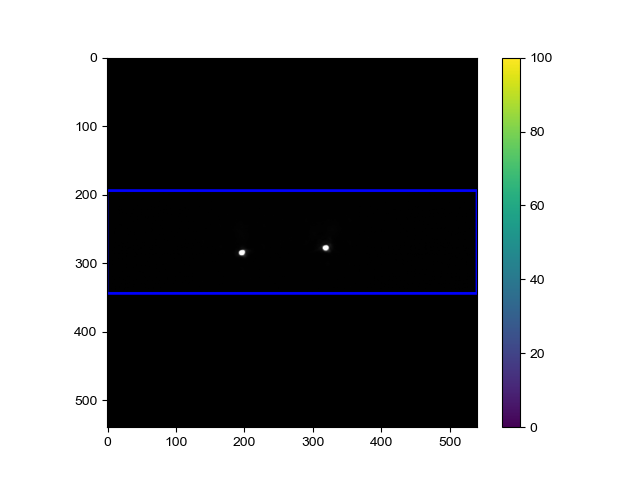

In [5]:
plt.figure()
plt.imshow(fov_data_dict['_lock_cam.png'][0], vmin=0, vmax=100)
plt.colorbar()

In [6]:
np.stack(fov_data_dict['_lock_cam.png']).shape

(40, 540, 540, 3)

In [7]:
import imagecodecs

In [8]:
from tifffile import TiffWriter
_key = '_lock_cam.png'
_save_filename = os.path.join(data_folder, f"fov-{fov_id}_{_key}{os.extsep}tif")
with TiffWriter(_save_filename) as _tif_fp:
    for _frame in fov_data_dict[_key]:
        _tif_fp.write(_frame, contiguous=True, photometric='rgb', dtype=_frame.dtype, 
                      compression='zstd')


ValueError: contiguous cannot be used with compression, tiles, etc.

In [27]:
#_key = '_lock_cam.png'
_key = '.dax'

In [62]:
_start_time = time.time()
byte_im = np.concatenate(fov_data_dict[_key][:batch_size]).tobytes()
print(f"{time.time()-_start_time:.2f}s")

3.18s


In [74]:
batch_size=1

In [82]:
compression_level = 2 # fast for zstandard
compression_type = 'zstd'

12

In [89]:
_start_time = time.time()
blosc.set_nthreads(os.cpu_count())
compressed_im = blosc.pack_array(np.concatenate(fov_data_dict[_key][:batch_size]), 
                                 cname=compression_type, clevel = compression_level)
print(f"{time.time()-_start_time:.2f}s")

1.27s


In [76]:
write_compressed(os.path.join(data_folder, f"test.zstd"), compressed_im)

In [77]:
fov_data_dict['file_table']['.dax'][0]

'D:\\20210515-proB_Dox_IAA_STI_CTP-08_2color\\H0R0\\Conv_zscan_00.dax'

In [65]:
_start_time = time.time()
compressed_im = blosc.compress(byte_im, cname=compression_type, clevel = compression_level, )
print(f"{time.time()-_start_time:.2f}s")

TypeError: pack_array() got an unexpected keyword argument 'chunksize'

In [57]:
fov_data_dict['.dax'][0].shape

(180, 2048, 2048)

In [22]:
def write_compressed(filepath, bytedata):
    with open(filepath, 'wb') as f:
        f.write(bytedata)

In [15]:
byte_im = np.stack(fov_data_dict['_lock_cam.png']).tobytes()

15.8 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
comp_png = blosc.compress()

In [11]:
import blosc

In [76]:
?imwrite

In [36]:
time.localtime()

time.struct_time(tm_year=2021, tm_mon=7, tm_mday=1, tm_hour=13, tm_min=29, tm_sec=36, tm_wday=3, tm_yday=182, tm_isdst=1)

In [ ]:
import os
import sys
import blosc
import time

def read_data(filename):
    with open(filename, 'rb') as f:
        return f.read()

def write_compressed(filepath, bytedata):
    with open(filepath, 'wb') as f:
        f.write(bytedata)

if __name__ == "__main__":
    
    # choose the compression and file extension you want here
    # zstandard gives good compression rates and is fast for clevel = 1
    compression_type = 'zstd'
    compression_level = 1 # fast for zstandard
    file_ext = '.zst' # file extension to append to dax file
    
    # this will delete the dax file once the compressed file is written
    delete = True
    
    # check the data by reading it back in uncompressing, and checking against the original
    # unecessary...
    check = False
    
    
    for root, dirs, files in os.walk(os.getcwd()):
        for file in files:
            if file.endswith('.dax'):
                
                file_path = os.path.join(root, file)
                file_size = os.stat(file_path).st_size
                
                print('working on: ' + str(file_path))
                
                t0 = time.time()
                raw = read_data(file_path)
                
                t1 = time.time()
                compressed = blosc.compress(raw, cname = compression_type, clevel = compression_level)
                t2 = time.time()
                
                compressed_path = file_path + file_ext
                write_compressed(compressed_path, compressed)
                compressed_size = os.stat(compressed_path).st_size
                print('compression time: ' + '{:.2f}'.format(t2-t1))
                print('total time: ' + '{:.2f}'.format(t2-t0))
                
                # delete the uncompressed file after it is compressed 
                if delete:
                    deleted = False
                    if os.path.exists(compressed_path):
                        os.remove(file_path)
                        deleted = True
                        
                # read back in the data to see if it is the same
                if check:
                    decompressed = blosc.decompress(read_data(compressed_path))
                    sameQ = raw == decompressed


                logfile_path = os.path.join(root, 'compression_log.txt')
                
                # write something to a log
                with open(logfile_path, 'a+') as logfile:
                    logfile.write('compressing file: ' + file_path + '\n')
                    logfile.write('compression time: ' + '{:.2f}'.format(t2 - t1) + ' s\n' )
                    logfile.write('total time: ' + '{:.2f}'.format(t2 - t0) + ' s\n' )
                    logfile.write('compression amount: ' + str(int(compressed_size/1024)) + '/' + str(int(file_size/1024)) + '\t' + '{:.2f}'.format(100 * compressed_size/file_size) + '%\n')
                    
                    if check:
                        if  sameQ:
                            logfile.write('compression passed test\n')
                        else:
                            logfile.write('compression failed test\n')
                    if not delete:
                        logfile.write('dax file not removed\n')
                    else:
                        if deleted:
                            logfile.write('dax file removed\n')
                        else:
                            logfile.write('warning check files\n')
                    logfile.write('\n')